In [1]:
import pickle
from os.path import join

import random
import itertools
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Tensorflow, Keras stuff
import tensorflow as tf
from tensorflow import keras

# Pre-processing
from tensorflow.data import AUTOTUNE
from tensorflow.image import stateless_random_flip_left_right, stateless_random_flip_up_down,                             stateless_random_brightness, stateless_random_contrast,                             stateless_random_crop, pad_to_bounding_box, central_crop,                             rot90
                             
from tensorflow.keras.preprocessing.image import apply_affine_transform, random_shift, random_rotation, random_zoom, smart_resize
from zca import ZCA    #https://github.com/mwv/zca

# Create model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D, Dropout 
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint

# Reproducibility
from tensorflow.python.framework import ops
ops.reset_default_graph()   #tf.reset_default_graph()
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# Model

In [2]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(SpatialDropout2D(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(SpatialDropout2D(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))   # , kernel_regularizer=l2(1e-4)
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [3]:
""" from google.colab import drive
drive.mount('/gdrive') """

" from google.colab import drive\ndrive.mount('/gdrive') "

In [4]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

def one_hot(label):
    one_hot_matrix = np.zeros((len(label), 10))
    one_hot_matrix[range(len(label)),label] = 1 
    return one_hot_matrix

def data_augmentation(img, label):
    seed = (0,1)
    seed2 = (0,2)
    augmented_img = [img,
                     stateless_random_flip_left_right(img, seed=seed).numpy(),
                     stateless_random_flip_up_down(img, seed=seed).numpy(),
                     random_zoom(img, zoom_range=(0.7, 0.7), row_axis=0, col_axis=1, channel_axis=2),
                     smart_resize(stateless_random_crop(img, size=(28, 28, 3), seed=seed2), size=(32,32), interpolation="bicubic").numpy(),
                     smart_resize(stateless_random_crop(img, size=(24, 24, 3), seed=seed), size=(32,32), interpolation="bicubic").numpy(),
                     smart_resize(stateless_random_crop(img, size=(20, 20, 3), seed=seed2), size=(32,32), interpolation="bicubic").numpy(),
                     rot90(img).numpy(),
                     rot90(img, k=2).numpy(),
                     apply_affine_transform(img, shear=np.random.randint(10, 20), zx=0.8, zy=0.8, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect', order=3),
                     random_zoom(rot90(img, k=3).numpy(), zoom_range=(0.7, 0.7), row_axis=0, col_axis=1, channel_axis=2),
                     #random_shift(img, wrg=0.15, hrg=0.15, row_axis=0, col_axis=1, channel_axis=2),
                     #central_crop(img, 0.125), 
                     #stateless_random_brightness(img, max_delta=0.2, seed=seed).numpy(), bug atm need to divide by 255 first
                     #stateless_random_contrast(img, lower=0.2, upper=0.5, seed=seed).numpy(), bug atm need to divide by 255 first
                     #random_rotation(img, rg=90, row_axis=0, col_axis=1, channel_axis=2),
                    ]

    augmented_label = [label]*len(augmented_img)

    return augmented_img, augmented_label

# Data processing

In [5]:
DATADIR = '../data/cifar-10-batches-py/' # '../data/cifar-10-batches-py/' ; '/gdrive/MyDrive/cifar-10-batches-py/'

## Test data and label name

In [6]:
test_data = unpickle(join(DATADIR, 'test_batch'))
x_test = test_data["data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float64")
y_test = np.array(test_data["labels"])

labeldict = unpickle(join(DATADIR, 'batches.meta'))
label_names = labeldict["label_names"]
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Label

**Transportation**: 
- airplane
- ship 
- automobile, truck 

**Animal**: 
- bird 
- dog
- frog
- horse, deer

## Augmentation experiment  

In [7]:
""" # Test data
seed=(0,1)
test_data = unpickle(join(DATADIR, 'test_batch'))
X = test_data["data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int32")
Y = np.array(test_data["labels"])

i = 2000
plt.style.use('default')
plt.figure(1)
img = X[i]#/255
plt.imshow(img)
new_img=img
#new_img = random_shift(img, wrg=0.2, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
#new_img = random_zoom(img, zoom_range=(0.8, 0.8), row_axis=0, col_axis=1, channel_axis=2)
#new_img = random_rotation(img, rg=360, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=220)
new_img = apply_affine_transform(img, theta=0, 
                                       tx=0,#np.random.uniform(0, 0.25), 
                                       ty=0,#np.random.uniform(0, 0.25), 
                                       shear=np.random.randint(-20, 20),#np.random.uniform(0, 0.25), 
                                       zx=0.8,#np.random.uniform(0.75, 1), 
                                       zy=0.8,#np.random.uniform(0.75, 1), 
                                       row_axis=0, col_axis=1, channel_axis=2, 
                                       fill_mode='reflect', order=3)
#new_img = stateless_random_flip_up_down(img, seed=seed).numpy()
#new_img=[smart_resize(stateless_random_crop(img, size=(28, 28, 3), seed=seed), size=(32,32), interpolation="bicubic").numpy()/255,
#         smart_resize(stateless_random_crop(img, size=(28, 28, 3), seed=(0,3)), size=(32,32), interpolation="bicubic").numpy()/255]
#plt.hist(new_img.ravel(), bins=500)
#plt.show()
plt.figure(2)
plt.imshow(new_img)
plt.title(f"Image {i} label={label_names[Y[i]]} (num {Y[i]})") """

' # Test data\nseed=(0,1)\ntest_data = unpickle(join(DATADIR, \'test_batch\'))\nX = test_data["data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int32")\nY = np.array(test_data["labels"])\n\ni = 2000\nplt.style.use(\'default\')\nplt.figure(1)\nimg = X[i]#/255\nplt.imshow(img)\nnew_img=img\n#new_img = random_shift(img, wrg=0.2, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode=\'nearest\')\n#new_img = random_zoom(img, zoom_range=(0.8, 0.8), row_axis=0, col_axis=1, channel_axis=2)\n#new_img = random_rotation(img, rg=360, row_axis=0, col_axis=1, channel_axis=2, fill_mode=\'constant\', cval=220)\nnew_img = apply_affine_transform(img, theta=0, \n                                       tx=0,#np.random.uniform(0, 0.25), \n                                       ty=0,#np.random.uniform(0, 0.25), \n                                       shear=np.random.randint(-20, 20),#np.random.uniform(0, 0.25), \n                                       zx=0.8,#np.random.uniform(0.75, 1), \n  

## Train data

In [8]:
""" val_counter = {c:0 for c in range(10)}
val_data = []
val_labels = [] """

amount_batch_to_use = 5
if 5 >= amount_batch_to_use > 0:
    trdata = []
    trlabels = []
    for batch_id in range(1, amount_batch_to_use+1):
        train_data = unpickle(join(DATADIR, f'data_batch_{batch_id}'))
        data = train_data["data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float64")
        label = train_data["labels"]
        for i in range(len(data)):
            aug_images, labels = data_augmentation(data[i], label[i])
            trdata.extend(aug_images) # aug_images, [data[i]]
            trlabels.extend(labels) # labels, [label[i]]

            ''' if val_counter[c] < 500:
                val_data.append(data[c])
                val_labels.append(c)
                val_counter[c] += 1
            else:
                trdata.extend([data[c]] + [data_augmentation(data[c]) for _ in range(3)])  # 4 times amount of training data
                trlabels.extend([c]*4) '''

    x_train, y_train = shuffle(np.array(trdata), np.array(trlabels))
    # x_val, y_val = np.array(val_data), np.array(val_labels)

else:
    raise RuntimeError(f"Expect amount_batch_to_use from 1 to 5. Current amount_batch_to_use: {amount_batch_to_use}")

## Pre-processing

In [9]:
# Normalization
x_train_mean  = np.mean(x_train,axis=0) 
x_train_std = np.std(x_train,axis=0)
print("mean shape", x_train_mean.shape)
#print(x_train_std)
x_train_process = (x_train-x_train_mean)/(x_train_std+1e-5)
x_test_process = (x_test-x_train_mean)/(x_train_std+1e-5)

# ZCA whitening
""" x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
trf = ZCA().fit(x_train)
x_train = trf.transform(x_train).reshape(x_train.shape[0], 32, 32, 3)
x_test = trf.transform(x_test).reshape(x_test.shape[0], 32, 32, 3) """

print("min", np.amin(x_train_process), "max", np.amax(x_train_process))

# One-hot encoding label vector
y_test_onehot = one_hot(y_test)
y_train_onehot = one_hot(y_train)
#y_val_onehot = one_hot(y_val)

mean shape (32, 32, 3)
min -2.530572571832562 max 2.919342659922693


In [10]:
""" train_ds  = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot))
train_ds 
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x), y),
                      num_parallel_calls=AUTOTUNE)
                 .shuffle(0)
                 .batch(batch_size)
                 .prefetch(buffer_size=AUTOTUNE) """

' train_ds  = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot))\ntrain_ds \naug_ds = train_ds.map(lambda x, y: (data_augmentation(x), y),\n                      num_parallel_calls=AUTOTUNE)\n                 .shuffle(0)\n                 .batch(batch_size)\n                 .prefetch(buffer_size=AUTOTUNE) '

# Training

In [11]:
batch_size = 64
max_epoch = 300
optimizer = SGD(learning_rate=0.001, nesterov=True, momentum=0.9)   #Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

model_checkpoint = ModelCheckpoint('model_checkpoints/CIFAR10_epoch{epoch:02d}.h5', save_freq=25*(1+50000*11//64), save_weights_only=False)
history = model.fit(
    x_train_process,
    y_train_onehot,
    batch_size=batch_size,
    epochs=max_epoch,
    validation_data=(x_test_process, y_test_onehot), 
    callbacks=[model_checkpoint],
    #shuffle=False
)

Epoch 1/300
8594/8594 [==============================] - 66s 7ms/step - loss: 1.7957 - categorical_accuracy: 0.3305 - val_loss: 1.3409 - val_categorical_accuracy: 0.5124
Epoch 2/300
8594/8594 [==============================] - 61s 7ms/step - loss: 1.4947 - categorical_accuracy: 0.4553 - val_loss: 1.1121 - val_categorical_accuracy: 0.5959
Epoch 3/300
8594/8594 [==============================] - 62s 7ms/step - loss: 1.3332 - categorical_accuracy: 0.5193 - val_loss: 0.9714 - val_categorical_accuracy: 0.6595
Epoch 4/300
8594/8594 [==============================] - 62s 7ms/step - loss: 1.2303 - categorical_accuracy: 0.5590 - val_loss: 0.9064 - val_categorical_accuracy: 0.6823
Epoch 5/300
8594/8594 [==============================] - 62s 7ms/step - loss: 1.1614 - categorical_accuracy: 0.5854 - val_loss: 0.8313 - val_categorical_accuracy: 0.7063
Epoch 6/300
8594/8594 [==============================] - 62s 7ms/step - loss: 1.1063 - categorical_accuracy: 0.6054 - val_loss: 0.7724 - val_categoric

# Evaluation

In [12]:
# Save model
#model = tf.keras.models.save_model('model_checkpoints/CIFAR10_final.h5', save_weights_only=False)

# Load model
#model = tf.keras.models.load_model('model_checkpoints/CIFAR10_final.h5') 

results = model.evaluate(x_test_process, y_test_onehot, batch_size=512)
print("test loss, test acc:", results)

20/20 [==============================] - 1s 17ms/step - loss: 0.4185 - categorical_accuracy: 0.8648
test loss, test acc: [0.41852641105651855, 0.864799976348877]


Best loss at epoch 235 0.4, and accuracy 86.9%
Best accuracy at epoch 235 86.9%, and loss 0.4


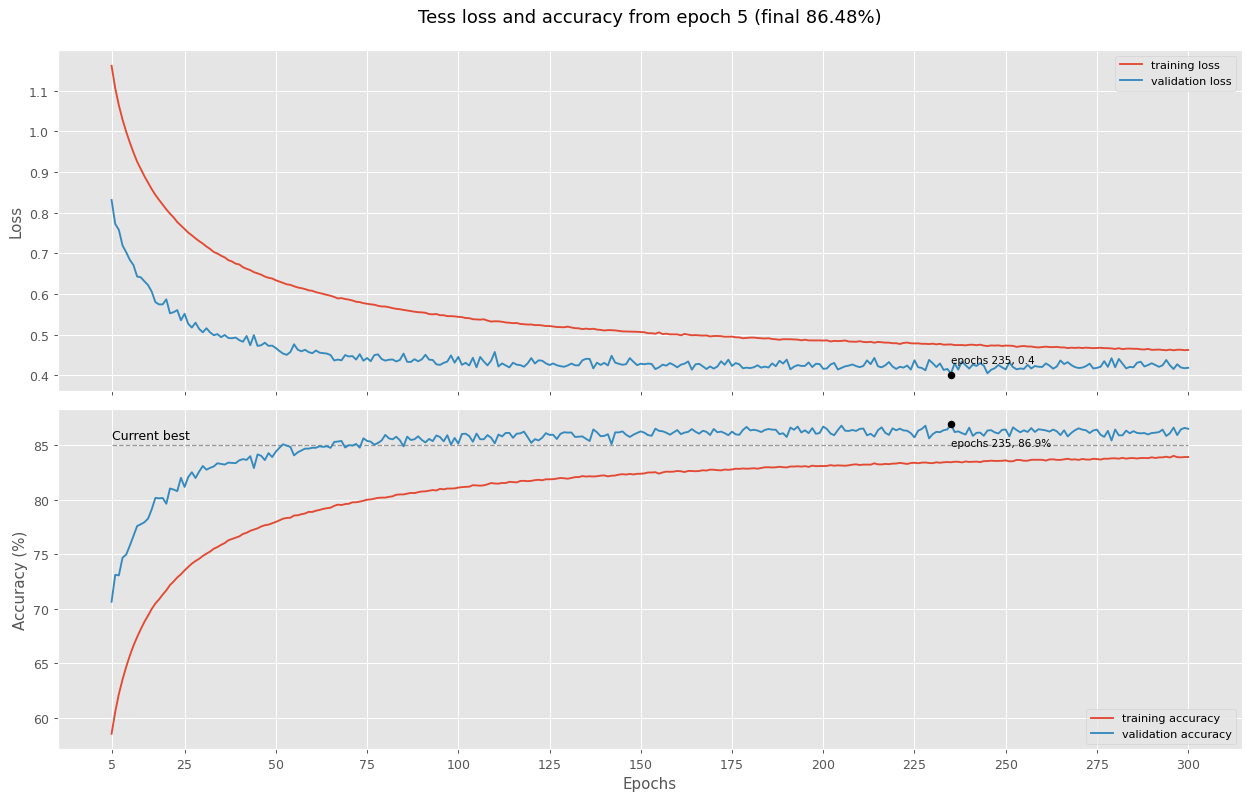

In [13]:
start_epoch = 5 # start from 1
start_epoch_id = start_epoch - 1
xticks = range(start_epoch, max_epoch + 1)

plt.rc('font', size=14)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=9)
plt.rcParams['figure.dpi'] = 90
plt.style.use('ggplot')

fig, (ax_loss, ax_acc) = plt.subplots(nrows=2, ncols=1, figsize=(14, 9), sharex=True)
ax_loss.set_title(f'Tess loss and accuracy from epoch 5 (final {results[1]*100:.2f}%)\n')

# Plot loss
ax_loss.plot(xticks, history.history['loss'][start_epoch_id:], label='training loss')
val_loss = history.history['val_loss']
ax_loss.plot(xticks, val_loss[start_epoch_id:], label='validation loss')
ax_loss.set_ylabel('Loss')
ax_loss.grid(True)
ax_loss.legend(loc="upper right")

# Annotate highest loss and its epoch (and accuracy)
best_loss_id = np.argmin(np.array(val_loss))
best_loss = round(val_loss[best_loss_id], 2)
ax_loss.plot(best_loss_id+1, best_loss, 'ko', markersize=5)
x_shift, y_shift = 1, 0.03
ax_loss.annotate(f"epochs {best_loss_id+1}, {best_loss}", xy=(best_loss_id, best_loss), xytext=(best_loss_id+x_shift, best_loss+y_shift), fontsize="small") 


# Plot accuracy
ax_acc.plot(xticks, np.array(history.history['categorical_accuracy'][start_epoch_id:])*100, label='training accuracy')
val_acc = np.around(np.array(history.history['val_categorical_accuracy'])* 100, decimals=4) 
ax_acc.plot(xticks, val_acc[start_epoch_id:], label='validation accuracy')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy (%)')
ax_acc.grid(True)
ax_acc.legend(loc='lower right')

# Plot current best
current_best_acc = 85.00 
ax_acc.hlines(y=current_best_acc, xmin=5, xmax=max_epoch, linewidth=1, linestyles="dashed", color="#000000", alpha=0.4)
ax_acc.annotate("Current best", xy=(5, current_best_acc+0.5), fontsize="medium")

# Annotate highest accuracy and its epoch (and loss)
best_acc_id = np.argmax(np.array(val_acc))
best_acc = val_acc[best_acc_id]
ax_acc.plot(best_acc_id+1, best_acc, 'ko', markersize=5)
x_shift, y_shift = 1, -2
ax_acc.annotate(f"epochs {best_acc_id+1}, {best_acc}%", xy=(best_acc_id, best_acc), xytext=(best_acc_id+x_shift, best_acc+y_shift), fontsize="small")

# Fixing xlabel ticks
epochs_list = range(0, max_epoch + 1, 25)
for i, num in enumerate(epochs_list):
    if num > start_epoch:
        xticks_plot = [start_epoch] + list(epochs_list[i:])
        break
ax_acc.xaxis.set_ticks(xticks_plot)
""" ax_acc.xaxis.set_major_locator(mticker.MaxNLocator(5))
ticks_loc = ax_acc.get_xticks().tolist()
ax_acc.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax_acc.set_xticklabels([x for x in ticks_loc]) """

print(f"Best loss at epoch {best_loss_id+1} {best_loss}, and accuracy {val_acc[best_loss_id]}%")
print(f"Best accuracy at epoch {best_acc_id+1} {best_acc}%, and loss {round(val_loss[best_acc_id], 2)}")

fig.tight_layout()
plt.show()

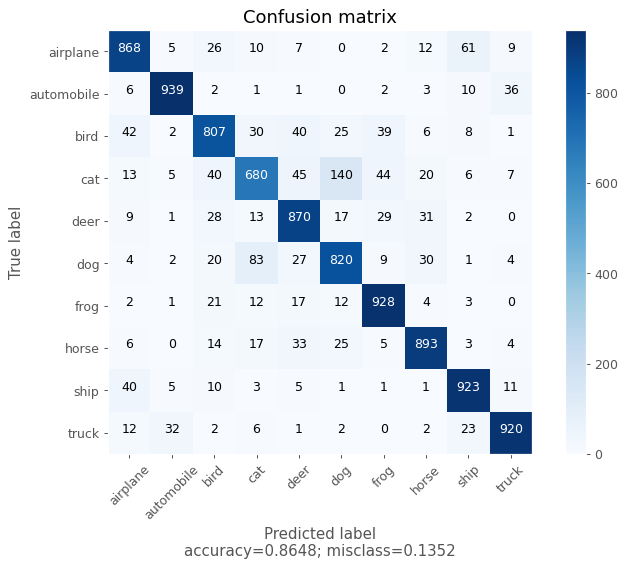

In [14]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/notebook
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):  

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid(False)
    plt.show()

onehot_prediction = model(x_test_process)
prediction = tf.math.argmax(onehot_prediction, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, prediction, num_classes=10).numpy()

plot_confusion_matrix(cm=confusion_matrix,
                      normalize=False,
                      target_names=label_names)

In [15]:
# Pick cat with highest probability of dog
test_data = unpickle(join(DATADIR, 'test_batch'))
X = test_data["data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int32")

cat_onehot_list = onehot_prediction[y_test==3].numpy()
sort_id_big_cat = np.argsort(cat_onehot_list[:,5])

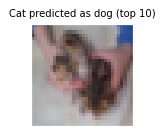

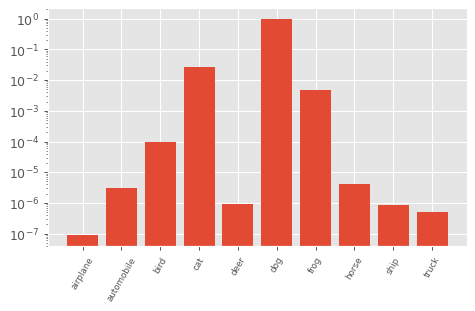

In [16]:
top = 10
misclassified_dog_id = sort_id_big_cat[-top]
cat_img = x_test[y_test==3]     # _process

plt.figure(figsize=(1.5,1.5))
plt.imshow(np.squeeze(cat_img[misclassified_dog_id]).astype('int'))
plt.grid(False)
plt.title(f"Cat predicted as dog (top {top})", fontsize=8)
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(6,3.5))
plt.bar(range(10), cat_onehot_list[misclassified_dog_id])
plt.yscale('log')
plt.xticks(range(10), label_names, rotation=60, fontsize=7)
plt.gca().yaxis.grid(True)
plt.show()

# Compare to other machine learning methods

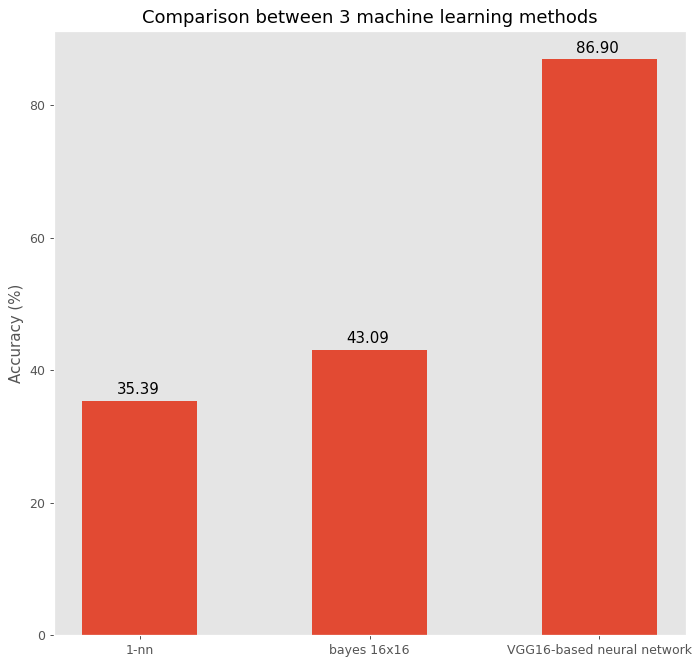

In [17]:
xaxis = range(3)
accuracy_list = [35.39, 43.09, best_acc]
fig, ax = plt.subplots(figsize=(8, 7.5))
ax.set_title("Comparison between 3 machine learning methods")
ax.bar(xaxis, accuracy_list, width=0.5, tick_label=["1-nn", "bayes 16x16", "VGG16-based neural network"])
ax.set_ylabel("Accuracy (%)")
        
for i, acc in enumerate(accuracy_list):
    ax.annotate(f"{acc:.2f}", xy=(i-0.1, acc+1), fontsize=12)

plt.tight_layout()
plt.grid(False)
plt.show()